# Overview: 

This notebook is created to do tasks given in issue no #5: [Calibration plot](https://github.com/mozilla/PRESC/issues/5)


## Task


- Write a function to create a **calibration plot** given one or more binary classifiers and a test set. 
- For each model it would compute **predicted probabilities** for each test datapoint. 
    - These probability values should then be **binned** according to a scheme (eg. intervals of 10%)
    - the observed occurrence rate can be computed as the **proportion of true positive class** samples out of all samples in each bin. 
- The plot then displays the observed **occurrence rates vs the bin midpoints** for each model.

--- 

Here I will avoide other cell discription except which are related to calibration plot and focus on it. I discribed those earlier. 


--- 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [2]:
df = pd.read_csv("../../datasets/defaults.csv")

In [3]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})
# df.head()

In [4]:
# creating the target variable
y = df['def_pay'].copy()
# y.sample(5)

In [5]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X = df[features].copy()
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

In [6]:
# split the df into train and test, it is important these two do not communicate during the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
#train = y_train
#test = y_test

In [8]:
#train = df.iloc[:train.shape[0], :]
#test = df.iloc[train.shape[0]:, :]

In [9]:
#print(train.shape)
#print(test.shape)

# Calibration plot


A calibration plot assesses how well the predicted class probabilities match the actual rate of occurrence in the dataset.






In [10]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

# For binary classification tasks predict_proba returns a matrix containing the first class proba in the first entry,
# and the second class proba in the second entry. Since there are only two classes one is just 1 - n of the other.
# The calibration_curve implementation expects just one of these classes in an array, so we index that.
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

c:\users\humayra\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The calibration curve works by sorting the probabilities assigned to the records being predicted by the probability reported by the classifier. It then bins the values, and calculates two things.

The `fraction_of_positives` is the percentage of records in the chosen bin which actually belong to the dominant class. This is determined by looking at what values these points are actually assigned in  y.

In [11]:
fraction_of_positives

array([0.0761347 , 0.15217391, 0.19904711, 0.32315789, 0.52941176])

The second thing returned,` mean_predicted_value`, is the mean probability of these points belonging to the dominant class reported by the algorithm.

In [12]:
mean_predicted_value

array([0.05461527, 0.15341548, 0.25089874, 0.34282278, 0.40807919])

# Logistic Regression Calibration Curve

If the classifier is forecasting probabilities (via `predict_proba`, if the classifier supports this method; more on that later) that are accurate, then we expect the percentage of dominant class classifications and the mean probabilities assigned to the dominant classes in each bin to be close to one another. If it is not doing so accurately, then we will see these two values diverge.

We can then display our results in a simple line plot to inspect what we got:



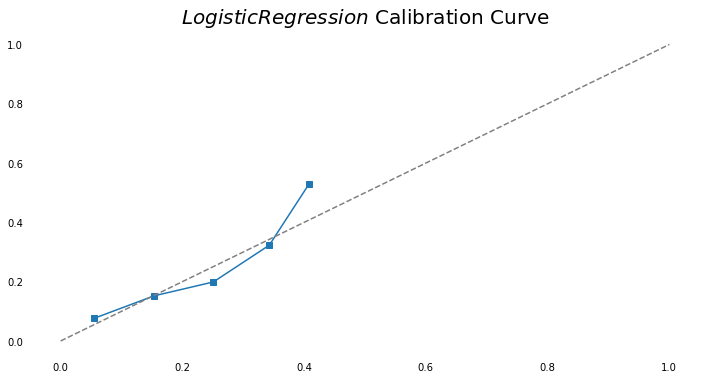

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$LogisticRegression$ Calibration Curve", fontsize=20); pass

We see here that LogisticRegression generates probability predictions that are ALMOST close to optimal. Some of this is due to the simplicity of the dataset that we are using, but most of this is due to logistic regression itself. Logistic regression tends to have quite accurate probability predictions because it is optimizing log-odds, which is just a convenient restatement of class probability! In other words, probability figures directly in the cost function that LogisticRegression solves for, and hence, unsurprisingly, the algorithm produces unbiased probability estimates.

Here's an example of an algorithm which does this poorly: GaussianNB

# GaussianNB   Calibration Curve

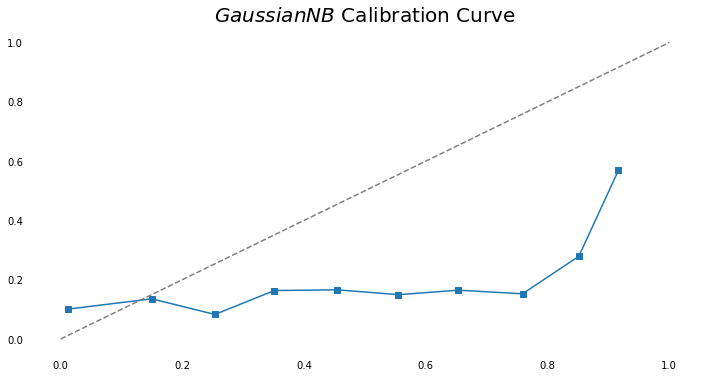

In [14]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$GaussianNB$ Calibration Curve", fontsize=20); pass

Naive Bayes algorithms will tend to push probabilities relatively near to, but not all the way at, 0 and 1. This is due to the fact that this algorithm assumes conditional independence of every feature in the dataset, a fairly ridiculous assumption that breaks down very quickly when there is redundancy in the dataset (e.g. columns containing similar information, and hence being non-independent).

# Random Forest Classifier Calibration Curve

c:\users\humayra\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


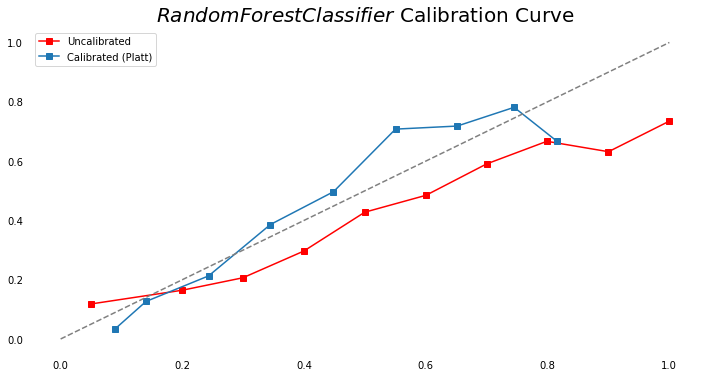

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 6))

# Create an uncorrected classifier.
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Uncalibrated')

# Create a corrected classifier.
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
y_test_predict_proba = clf_sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibrated (Platt)')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().legend()
plt.title("$RandomForestClassifier$ Calibration Curve", fontsize=20); pass

Here the RandomForestClassifier was already returning relatively accurate probability scores, so a correction wasn't strictly necessary. Still, we see that applying the Platt transformation did perhaps further reduce the bias.

# GaussianNB Calibration Curve

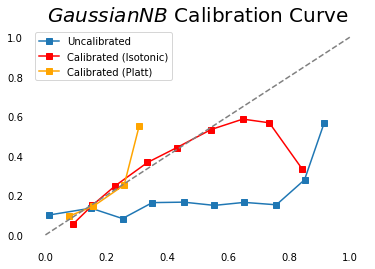

In [16]:
# Uncalibrated
clf = GaussianNB()
clf.fit(X_train, y_train)
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Uncalibrated')

# Calibrated
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='isotonic')
clf_sigmoid.fit(X_train, y_train)
y_test_predict_proba = clf_sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
y_test_predict_proba = clf_sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='orange', label='Calibrated (Platt)')


plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().legend()
plt.title("$GaussianNB$ Calibration Curve", fontsize=20); pass


In the blue we have the calibration curve for the original GaussianNB classifier.

In the yellow is the recalibrated curve we generated with a Platt correction. We see here that the Platt correction actually did good. When we look at the original calibration curves for the various algorithms, we see that for the data used in that example, GaussianNB did not truly have the same sigmoidal error structure that SVC and RandomForest have. For this data, it overshoots the low probabilities by too little, and undershoots the high-probability data by too much. Platt calibration works when the amount of bias on either side is close to the same, and it fails (rather to my surprise) here.

Isotonic calibration, on the other hand, really gets the job done. We see here that the isotonic adjusted probabilities, in red, are a very close match to the true mean probabilities.

However, Isotonic calibration gives better performance only for sufficiently large datasets, like our dataset which has 24000 samples. Isotonic calibration has a strong tendancy to overfit.


# Comparison of Calibration of Classifiers


Well calibrated classifiers are probabilistic classifiers for which the output
of the predict_proba method can be directly interpreted as a confidence level.
For instance a well calibrated (binary) classifier should classify the samples
such that among the samples to which it gave a predict_proba value close to
0.8, approx. 80% actually belong to the positive class.

LogisticRegression returns well calibrated predictions as it directly
optimizes log-loss. In contrast, the other methods return biased probabilities,
with different biases per method:

* GaussianNaiveBayes tends to push probabilities to 0 or 1 (note the counts in
  the histograms). This is mainly because it makes the assumption that features
  are conditionally independent given the class, which is not the case in this
  dataset which contains 2 redundant features.

* RandomForestClassifier shows the opposite behavior: the histograms show
  peaks at approx. 0.2 and 0.9 probability, while probabilities close to 0 or 1
  are very rare. An explanation for this is given by Niculescu-Mizil and Caruana
  [1]_: "Methods such as bagging and random forests that average predictions
  from a base set of models can have difficulty making predictions near 0 and 1
  because variance in the underlying base models will bias predictions that
  should be near zero or one away from these values. Because predictions are
  restricted to the interval [0,1], errors caused by variance tend to be one-
  sided near zero and one. For example, if a model should predict p = 0 for a
  case, the only way bagging can achieve this is if all bagged trees predict
  zero. If we add noise to the trees that bagging is averaging over, this noise
  will cause some trees to predict values larger than 0 for this case, thus
  moving the average prediction of the bagged ensemble away from 0. We observe
  this effect most strongly with random forests because the base-level trees
  trained with random forests have relatively high variance due to feature
  subsetting." As a result, the calibration curve shows a characteristic
  sigmoid shape, indicating that the classifier could trust its "intuition"
  more and return probabilities closer to 0 or 1 typically.

* Support Vector Classification (SVC) shows an even more sigmoid curve as
  the  RandomForestClassifier, which is typical for maximum-margin methods
  (compare Niculescu-Mizil and Caruana [1]_), which focus on hard samples
  that are close to the decision boundary (the support vectors).


c:\users\humayra\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


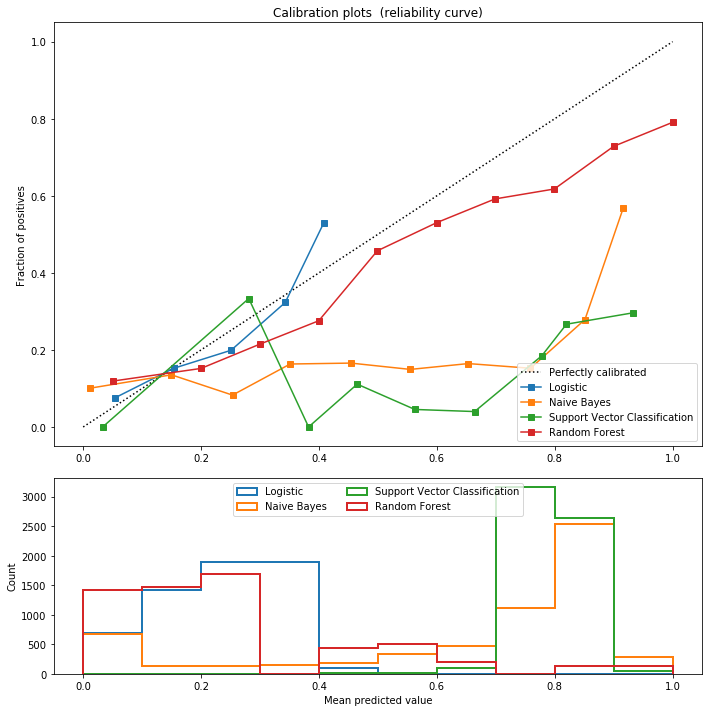

In [17]:
np.random.seed(0)

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()


# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Probability Calibration curves

When performing classification one often wants to predict not only the class label, but also the associated probability. This probability gives some kind of confidence on the prediction. This example demonstrates how to display how well calibrated the predicted probabilities are and how to calibrate an uncalibrated classifier.



In [18]:
def model_pred(clf, X_test):
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    return prob_pos

Here this function shows the estimated probabilities obtained with logistic regression, a linear support-vector classifier (SVC), and linear SVC with both isotonic calibration and sigmoid calibration. 

The **Brier score** is a metric which is a combination of calibration loss and refinement loss, brier_score_loss, reported in the legend (the smaller the better). 

**Calibration loss** is defined as the mean squared deviation from empirical probabilities derived from the slope of ROC segments.

**Refinement loss** can be defined as the expected optimal loss as measured by the area under the optimal cost curve.



In [19]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        prob_pos = model_pred(clf, X_test) 
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)


    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

c:\users\humayra\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic:
	Brier: 0.167
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes:
	Brier: 0.404
	Precision: 0.246
	Recall: 0.883
	F1: 0.385

Naive Bayes + Isotonic:
	Brier: 0.157
	Precision: 0.558
	Recall: 0.180
	F1: 0.272

Naive Bayes + Sigmoid:
	Brier: 0.165
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


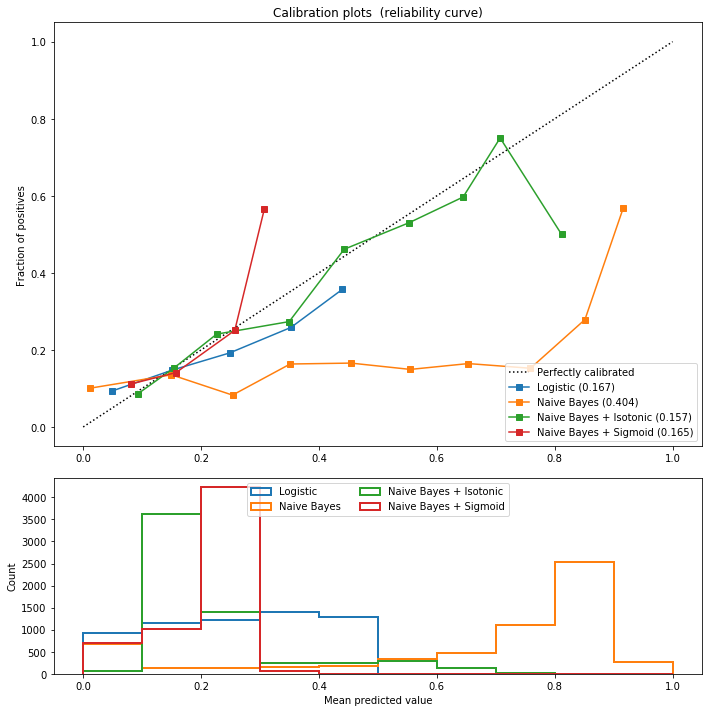

In [20]:
# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

We can see that Gaussian naive Bayes performs very badly along with does so in an other way than linear SVC: While linear SVC exhibited a sigmoid calibration curve, Gaussian naive Bayes’ calibration curve has a transposed-sigmoid shape. This is typical for an over-confident classifier. In this case, the classifier’s overconfidence is caused by the redundant features which violate the naive Bayes assumption of feature-independence.

Calibration of the probabilities of Gaussian naive Bayes with isotonic regression can fix this issue as can be seen from the nearly diagonal calibration curve. Sigmoid calibration also improves the brier score slightly, albeit not as strongly as the non-parametric isotonic regression. This can be attributed to the fact that we have plenty of calibration data such that the greater flexibility of the non-parametric model can be exploited.

c:\users\humayra\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic:
	Brier: 0.167
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC:
	Brier: 0.345
	Precision: 0.268
	Recall: 0.570
	F1: 0.365



c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC + Isotonic:
	Brier: 0.165
	Precision: 0.587
	Recall: 0.021
	F1: 0.040



c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC + Sigmoid:
	Brier: 0.168
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



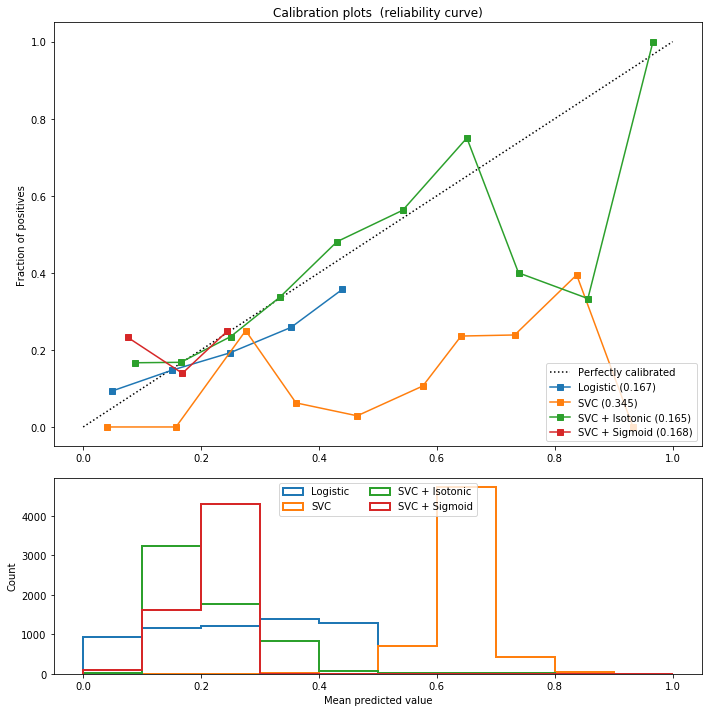

In [21]:
# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plt.show()

We can observe here that logistic regression is well calibrated as its curve is nearly diagonal. Linear SVC’s calibration curve or reliability diagram has a sigmoid curve, which is typical for an under-confident classifier. In the case of LinearSVC, this is caused by the margin property of the hinge loss, which lets the model focus on hard samples that are close to the decision boundary (the support vectors). Both kinds of calibration can fix this issue and yield nearly identical results. 




Both kinds of calibration can fix this issue and yield nearly identical results. This shows that sigmoid calibration can deal with situations where the calibration curve of the base classifier is sigmoid (e.g., for LinearSVC) but not where it is transposed-sigmoid (e.g., Gaussian naive Bayes).